# preprocessing prototype code

In [1]:
#from dask_jobqueue import SLURMCluster
import pyremo as pr
import xarray as xr
from dask.distributed import Client, progress

no python-cdo binding installed, unable to read IEG


In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:41154 Dashboard: /user/g300046/advanced//proxy/8787/status,Cluster Workers: 8 Cores: 48 Memory: 262.14 GB


In [3]:
ta_file = "/pool/data/CMIP6/data/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r1i1p1f1/6hrLev/ta/gn/v20190710/ta_6hrLev_MPI-ESM1-2-HR_historical_r1i1p1f1_gn_197901010600-198001010000.nc"
ps_file = "/pool/data/CMIP6/data/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r1i1p1f1/6hrLev/ps/gn/v20190710/ps_6hrLev_MPI-ESM1-2-HR_historical_r1i1p1f1_gn_197501010600-198001010000.nc"
hus_file = "/pool/data/CMIP6/data/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r1i1p1f1/6hrLev/hus/gn/v20190710/hus_6hrLev_MPI-ESM1-2-HR_historical_r1i1p1f1_gn_197901010600-198001010000.nc"
ua_file = "/pool/data/CMIP6/data/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r1i1p1f1/6hrLev/ua/gn/v20190815/ua_6hrLev_MPI-ESM1-2-HR_historical_r1i1p1f1_gn_197901010600-198001010000.nc"
va_file = "/pool/data/CMIP6/data/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r1i1p1f1/6hrLev/va/gn/v20190815/va_6hrLev_MPI-ESM1-2-HR_historical_r1i1p1f1_gn_197901010600-198001010000.nc"
orog_file = "/pool/data/CMIP6/data/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r1i1p1f1/fx/orog/gn/v20190710/orog_fx_MPI-ESM1-2-HR_historical_r1i1p1f1_gn.nc"

input_files = [orog_file, ta_file, ps_file, hus_file, ua_file, va_file]

In [4]:
datasets = {'ta': ta_file, 
            'ps': ps_file,
            'hus': hus_file,
            'ua': ua_file,
            'va': va_file,
            #'orog': orog_file
           }

In [5]:
def open_mfdataset(files, use_cftime=True, parallel=True, data_vars='minimal', chunks={'time':1}, 
                   coords='minimal', compat='override', drop=None, **kwargs):
    """optimized function for opening CMIP6 6hrLev 3d datasets

    based on https://github.com/pydata/xarray/issues/1385#issuecomment-561920115
    
    """
    def drop_all_coords(ds):
        #ds = ds.drop(drop)
        return ds.reset_coords(drop=True)
    ds = xr.open_mfdataset(files, parallel=parallel, decode_times=False, combine='by_coords', 
                       preprocess=drop_all_coords, decode_cf=False, chunks=chunks,
                      data_vars=data_vars, coords='minimal', compat='override', **kwargs)
    return xr.decode_cf(ds, use_cftime=use_cftime)

In [6]:
ds = open_mfdataset(ta_file)

In [21]:
from pyintorg import interface as intf


def horizontal_dims(da):
    for dim in da.dims:
        if 'lon' in dim:
            lon_dim = dim
        if 'lat' in dim:
            lat_dim = dim
    return (lon_dim, lat_dim)


def intersect(lamgm, phigm, lamem, phiem):
    gcm_dims = list(horizontal_dims(lamgm))
    rcm_dims = list(horizontal_dims(lamem))
    rcm_dims.append('pos')
    out_dims = rcm_dims
    #print(gcm_dims)
    #print(rcm_dims)
    #print(out_dims)
    result = xr.apply_ufunc(
        intf.intersection_points,  # first the function
        lamgm*1.0/57.296,  # now arguments in the order expected by 'druint'
        phigm*1.0/57.296,
        lamem*1.0/57.296,
        phiem*1.0/57.296,
        input_core_dims=[gcm_dims, gcm_dims, rcm_dims, rcm_dims],  # list with one entry per arg
        output_core_dims=[out_dims, out_dims],  # returned data has 3 dimensions
     #   vectorize=True,  # loop over non-core dims, in this case: time
     #   exclude_dims=set(("lev",)),  # dimensions allowed to change size. Must be a set!
        dask="parallelized",
        output_dtypes=[lamgm.dtype]
    )
    return result


def interpolate_horizontal(da, lon, lat, name=None, igr=0):
    if name is None:
        name = da.name
    lamem, phiem = lon, lat
    #lamem = xr.concat([lamem, lamem, lamem], dim='pos')
    #phiem = xr.concat([phiem, phiem, phiem], dim='pos')
    lat2d, lon2d = xr.broadcast(ds.lat, ds.lon)
    lamgm, phigm = lon2d, lat2d
    indii, indjj = intersect(lamgm, phigm, lamem, phiem)
    return interp_horiz(da, lamgm, phigm,
                        lamem.isel(pos=igr), phiem.isel(pos=igr),
                        indii.isel(pos=igr), indjj.isel(pos=igr), name)


def interp_horiz_2d(field, lamgm, phigm, lamem, phiem, indii, indjj, name):
    """interpolates 2d global data horizontally.

    Interpolates 2d data from the global grid to the regional grid.
    """
    from intorg import intorg
    #if indii is None or indjj is None:
    #    indii, indjj = intersection_points(lamgm, phigm, lamem, phiem)
    return intorg.hiobla(field, lamgm, phigm, lamem, phiem, indii, indjj, name)


def interp_horiz(da, lamgm, phigm, lamem, phiem, indii, indjj, name, keep_attrs=False): 
    """main interface"""
    gcm_dims = list(horizontal_dims(lamgm))
    rcm_dims = list(horizontal_dims(lamem))
    input_core_dims = [gcm_dims, gcm_dims, gcm_dims, rcm_dims, rcm_dims , rcm_dims, rcm_dims, [] ]
    result = xr.apply_ufunc(
        interp_horiz_2d,  # first the function
        da,  # now arguments in the order expected
        lamgm*1.0/57.296,
        phigm*1.0/57.296,
        lamem*1.0/57.296,
        phiem*1.0/57.296,
        indii,
        indjj,
        name,
        input_core_dims=input_core_dims,  # list with one entry per arg
        output_core_dims=[rcm_dims],  # returned data has 3 dimensions
        vectorize=True,  # loop over non-core dims, in this case: time
      #  exclude_dims=set(("lev",)),  # dimensions allowed to change size. Must be a set!
        dask="parallelized",
        dask_gufunc_kwargs = {'allow_rechunk':True}, 
        output_dtypes=[da.dtype]
    )

    result.name = name
    #result = result.to_dataset()
    if keep_attrs:
        result.attrs = da.attrs
    #result = result.transpose(..., *spatial_dims(da)[::-1])
    return result

def geopotential(fibgm, tgm, qdgm, psgm, akgm, bkgm):
    """main interface"""
    #gcm_dims = list(spatial_dims(lamgm))
    twoD_dims = list(horizontal_dims(fibgm))
    threeD_dims = list(horizontal_dims(fibgm))
    threeD_dims.append("lev")
    #lev_dims.append("lev")
    #plev_dims = list(spatial_dims(da))
    #plev_dims.append("plev")
    #nlev = a.dims[0]
    input_core_dims = [twoD_dims, threeD_dims, threeD_dims, twoD_dims, ["lev_2"], ["lev_2"]]
    result = xr.apply_ufunc(
        intf.geopotential,  # first the function
        fibgm,  # now arguments in the order expected
        tgm,
        qdgm,
        psgm,
        akgm,
        bkgm,
        input_core_dims=input_core_dims,  # list with one entry per arg
      #  output_core_dims=[threeD_dims],  # returned data has 3 dimensions
        output_core_dims=[twoD_dims],  # returned data has 3 dimensions
       # vectorize=True,  # loop over non-core dims, in this case: time
       # exclude_dims=set(("lev",)),  # dimensions allowed to change size. Must be a set!
        dask="parallelized",
      #  dask_gufunc_kwargs = {'allow_rechunk':True}, 
        output_dtypes=[fibgm.dtype]
    )
    return result


def relative_humidity(qdgm, tgm, psgm, akgm, bkgm, qwgm=None):
    """main interface"""
    if qwgm is None:
        qwgm = xr.zeros_like(qdgm)
    twoD_dims = list(horizontal_dims(qdgm))
    threeD_dims = list(horizontal_dims(qdgm)) + ['lev']
  #  print(twoD_dims)
    #threeD_dims.append("lev")
    input_core_dims = [threeD_dims, threeD_dims, twoD_dims, ["lev_2"], ["lev_2"], threeD_dims]
    result = xr.apply_ufunc(
        intf.relative_humidity,  # first the function
        qdgm,  # now arguments in the order expected
        tgm,
        psgm,
        akgm,
        bkgm,
        qwgm,
        input_core_dims=input_core_dims,  # list with one entry per arg
      #  output_core_dims=[threeD_dims],  # returned data has 3 dimensions
        output_core_dims=[threeD_dims],  # returned data has 3 dimensions
        vectorize=True,  # loop over non-core dims, in this case: time
       # exclude_dims=set(("lev",)),  # dimensions allowed to change size. Must be a set!
        dask="parallelized",
      #  dask_gufunc_kwargs = {'allow_rechunk':True}, 
        output_dtypes=[qdgm.dtype]
    )
    return result


def geo_coords(domain):
    import numpy as np
    ll_lam = domain.rlon[0] #* 1.0/57.296
    ll_phi = domain.rlat[0] #* 1.0/57.296
    dlam =  0.11
    dphi = 0.11
    nlam = domain.rlon.size
    nphi = domain.rlat.size
    pollam = domain.rotated_latitude_longitude.grid_north_pole_longitude
    polphi = domain.rotated_latitude_longitude.grid_north_pole_latitude
    lamem, phiem = intf.geo_coords(ll_lam, ll_phi, dlam, dphi, pollam, polphi, nlam, nphi)
    lamda = xr.DataArray(np.rad2deg(lamem), dims=('rlon', 'rlat', 'pos'), coords={'rlon':domain.rlon, 'rlat':domain.rlat})
    phida = xr.DataArray(np.rad2deg(phiem), dims=('rlon', 'rlat', 'pos'), coords={'rlon':domain.rlon, 'rlat':domain.rlat})
    return lamda, phida


def rotate_uv(uge, vge, uvge, vuge, ulamem, uphiem, vlamem, vphiem, pollam, polphi):
    result = xr.apply_ufunc(
        intf.relative_humidity,  # first the function
        qdgm,  # now arguments in the order expected
        tgm,
        psgm,
        akgm,
        bkgm,
        qwgm,
        input_core_dims=input_core_dims,  # list with one entry per arg
      #  output_core_dims=[threeD_dims],  # returned data has 3 dimensions
        output_core_dims=[threeD_dims],  # returned data has 3 dimensions
        vectorize=True,  # loop over non-core dims, in this case: time
       # exclude_dims=set(("lev",)),  # dimensions allowed to change size. Must be a set!
        dask="parallelized",
      #  dask_gufunc_kwargs = {'allow_rechunk':True}, 
        output_dtypes=[qdgm.dtype]
    )
    return result

In [22]:
from pyremo import domain as dm
domain = dm.remo_domain('EUR-11')
#domain_info = dm.domain_info('AFR-11')
lamem, phiem = geo_coords(domain)

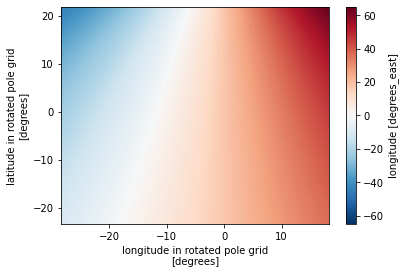

In [23]:
domain.lon.plot()

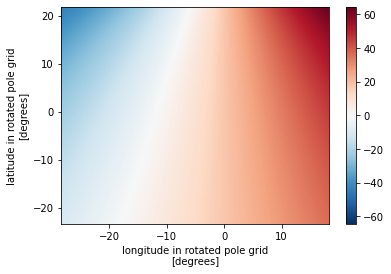

In [24]:
lamem.isel(pos=0).transpose().plot()

In [25]:
tge = interpolate_horizontal(ds.ta.sel(time="1979-01"), lamem, phiem)

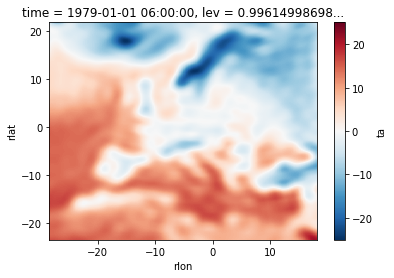

In [26]:
(tge.isel(time=0, lev=0)-273.5).plot(x='rlon', y='rlat')

In [12]:
tge_ = tge.persist()
progress(tge_)

VBox()

In [30]:
import numpy as np

def get_vc(ds):
    """Reads the vertical hybrid coordinate from a dataset.
    """
    ak_valid = ['ap_bnds','a_bnds']
    bk_valid = ['b_bnds']
    ak_bnds = None
    bk_bnds = None
    for ak_name in ak_valid:
        if ak_name in ds:
            ak_bnds = ds[ak_name]
            print('using {} for akgm'.format(ak_name))
    for bk_name in bk_valid:
        if bk_name in ds:
            bk_bnds = ds[bk_name]
            print('using {} for bkgm'.format(bk_name))
#    if not all([ak_bnds, bk_bnds]):
#        print('could not identify vertical coordinate, tried: {}, {}'.format(ak_valid, bk_valid))
#        raise Exception('incomplete input dataset')
#        ak_bnds, bk_bnds  = (ak_bnds[:1], bk_bnds[:,1])
    nlev = ak_bnds.shape[0]
    ak = np.zeros([nlev+1], dtype=np.float64)
    bk = np.ones([nlev+1], dtype=np.float64)
    if ds.lev.positive == "down":
        ak[:-1] = np.flip(ak_bnds[:,1])
        bk[:-1] = np.flip(bk_bnds[:,1])
    else:
        ak[1:] = np.flip(ak_bnds[:,1])
        bk[1:] = np.flip(bk_bnds[:,1])
        
    return xr.DataArray(ak, dims="lev_2"), xr.DataArray(bk, dims="lev_2")

def gfile(datasets, ref_ds, time_range = None):
    """Creates a virtual gfile
    """
    if time_range is None:
        time_range=slice("1979-01-01T06:00:00", "1979-01-31T18:00:00")
    dsets = []
    for var, f in datasets.items():
        da = open_mfdataset(f)[var].sel(time=time_range)
        try:
            if da.lev.positive == "down":
                da = da.reindex(lev=da.lev[::-1])
        except:
            pass
        dsets.append(da)
            
    #dsets = [open_mfdataset(f)[var].sel(time=time_range) for var, f in datasets.items()]
    #dsets.append(orog_ds.orog)
    ds = xr.merge(dsets, compat="override")
    ds["akgm"], ds["bkgm"] = get_vc(ref_ds)
    #ds["akgm"], ds["bkgm"] = get_vc(ref_ds)
    #if ds.lev.positive == "down":
    #    ds.reindex(lev=ds.lev[::-1])
    ds.attrs = ref_ds.attrs
    return ds

In [31]:
ref_ds = open_mfdataset(ta_file)
orog_ds = open_mfdataset(orog_file, chunks="auto")
orog_ds

<xarray.Dataset>
Dimensions:   (bnds: 2, lat: 192, lon: 384)
Coordinates:
  * lat       (lat) float64 -89.28 -88.36 -87.42 -86.49 ... 87.42 88.36 89.28
  * lon       (lon) float64 0.0 0.9375 1.875 2.812 ... 356.2 357.2 358.1 359.1
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (lat, bnds) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
    lon_bnds  (lon, bnds) float64 dask.array<chunksize=(384, 2), meta=np.ndarray>
    orog      (lat, lon) float32 dask.array<chunksize=(192, 384), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    contact:                cmip6-mpi-esm@dkrz.de
    ...                     ...
    title:                  MPI-ESM1-2-HR output prepared for CMIP6
    tracking_id:            hdl:21.14100/3341d289-1282-489f-9419-c263718da247
    variable_id:            orog
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0

In [32]:
ds = gfile(datasets, ref_ds, time_range = slice("1979-01-01T06:00:00", "1979-01-31T18:00:00"))

using ap_bnds for akgm
using b_bnds for bkgm


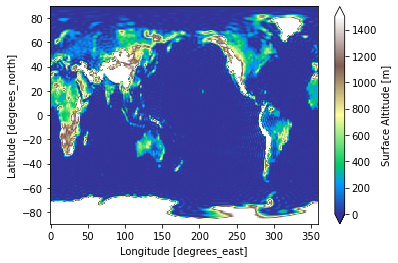

In [33]:
orog_ds["lon"] = ds.lon
orog_ds["lat"] = ds.lat
ds["orog"] = orog_ds.orog
ds.orog.plot(cmap="terrain", vmin=0, vmax=1500)

In [41]:
tge = interpolate_horizontal(ds.ta, lamem, phiem, 'T')
psge = interpolate_horizontal(ds.ps, lamem, phiem, 'PS')
uge = interpolate_horizontal(ds.ua, lamem, phiem, 'U', 1)
uvge = interpolate_horizontal(ds.ua, lamem, phiem, 'U', 2)
vge = interpolate_horizontal(ds.va, lamem, phiem, 'V', 2)
vuge = interpolate_horizontal(ds.va, lamem, phiem, 'V', 1)
qdge = interpolate_horizontal(ds.hus, lamem, phiem, 'QD')

### rotate UV

In [20]:
psge_ = psge.persist()
progress(psge_)

VBox()

In [36]:
ds

,Array,Chunk
Bytes,3.45 GB,28.02 MB
Shape,"(123, 95, 192, 384)","(1, 95, 192, 384)"
Count,3167 Tasks,123 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,36.27 MB,294.91 kB
Shape,"(123, 192, 384)","(1, 192, 384)"
Count,14732 Tasks,123 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [37]:
fibgm = ds.orog * 1.0/0.10197 # = gravitational constant if unit is 'm'
ficgm = geopotential(fibgm, ds.ta.isel(time=0), ds.hus.isel(time=0), ds.ps.isel(time=0), ds.akgm, ds.bkgm).squeeze(drop=True)
ficge = interpolate_horizontal(ficgm, lamem, phiem, 'FIC')
arfgm = relative_humidity(ds.hus, ds.ta, ds.ps, ds.akgm, ds.bkgm)
arfge = interpolate_horizontal(arfgm, lamem, phiem, 'AREL HUM')

In [ ]:
#RELHUM: hur relative_humidity
#QD hus specific_humidity
#QW: clw mass_fraction_of_cloud_liquid_water_in_air

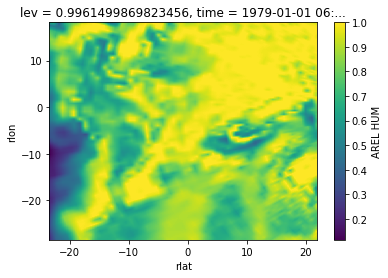

In [38]:
arfge.isel(time=0, lev=94).plot()

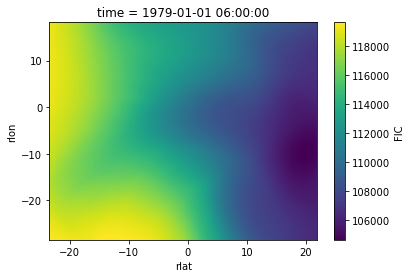

In [39]:
ficge.plot()

In [40]:
kpbl = intf.pbl_index(ds.akgm, ds.bkgm)
kpbl

89